In [1]:
# Si tu estructura es cython_dbscan/dbscan_core.so, asegúrate de incluir el path
import os, sys
project_root = os.path.abspath("..")       # ajusta según dónde esté el notebook
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Importa tu módulo compilado
from cython_dbscan.dbscan_core import dbscan

In [2]:
import numpy as np
import pandas as pd
from src.segmenter import segment_dataframe
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import matplotlib.pyplot as plt

df = pd.read_parquet('../Data/sample_jan_2021.parquet')
df.head()

,mmsi,longitude,latitude,imo,vessel_name,callsign,vessel_type,vessel_type_cargo,length,width,destination,draught,sog,cog,heading,nav_status,dt_pos_utc,vessel_type_main,H3_int_index_15,res_8
1172258,257600000.0,10.810000,55.746667,9854478,SYDSTRAUM,LAGH7,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,FI HMN > SE MMA,8.1,13.0,7.0,154.0,Under Way Using Engine,2021-01-01 00:00:50,None,644562452806690699,881f222c31fffff
1172259,257600000.0,10.810388,55.748605,9854478,SYDSTRAUM,LAGH7,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,FI HMN > SE MMA,8.1,13.4,6.6,8.0,Under Way Using Engine,2021-01-01 00:01:00,None,644562452806187528,881f222c31fffff
1172260,259372000.0,24.117868,57.007650,9118496,CHRISTINA,LIJG3,Tanker,No Additional Information,124.0,20.0,LV RIX,5.6,0.0,316.9,47.0,Moored,2021-01-01 00:01:05,Oil And Chemical Tanker,644566704828286749,881f600c35fffff
1172261,257550000.0,0.562263,54.127452,9854466,SALTSTRAUM,LAJU6,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,ANTWERP,6.0,13.7,136.3,138.0,Under Way Using Engine,2021-01-01 00:01:14,None,644459251375659225,88194464e7fffff
1172262,257550000.0,0.561667,54.126667,9854466,SALTSTRAUM,LAJU6,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,ANTWERP,6.0,13.0,136.0,0.0,Under Way Using Engine,2021-01-01 00:01:17,None,644459251374645290,88194464e7fffff


In [18]:
df = df.reset_index(drop=True)
df_opt, errores = segment_dataframe(df, eps=0.1, min_samples=5)

Segmentación completada en 0.49 segundos


In [19]:
all_labels_sklearn = -np.ones(len(df), dtype=np.int32)
cluster_counter = 0

for res8_id, group in tqdm(df.groupby("res_8")):
    if len(group) < 10 or len(group) > 10000:
        continue

    coords = np.ascontiguousarray(group[["latitude", "longitude"]].to_numpy(dtype=np.float64))

    model = DBSCAN(eps=0.5, min_samples=10)
    labels = model.fit_predict(coords)

    max_label = labels.max()
    if max_label > -1:
        labels = np.where(labels != -1, labels + cluster_counter, -1)
        cluster_counter += max_label + 1

    all_labels_sklearn[group.index.to_numpy()] = labels  # ✅ clave

df_opt["cluster_sklearn"] = all_labels_sklearn

100%|██████████| 40329/40329 [00:00<00:00, 68166.60it/s]


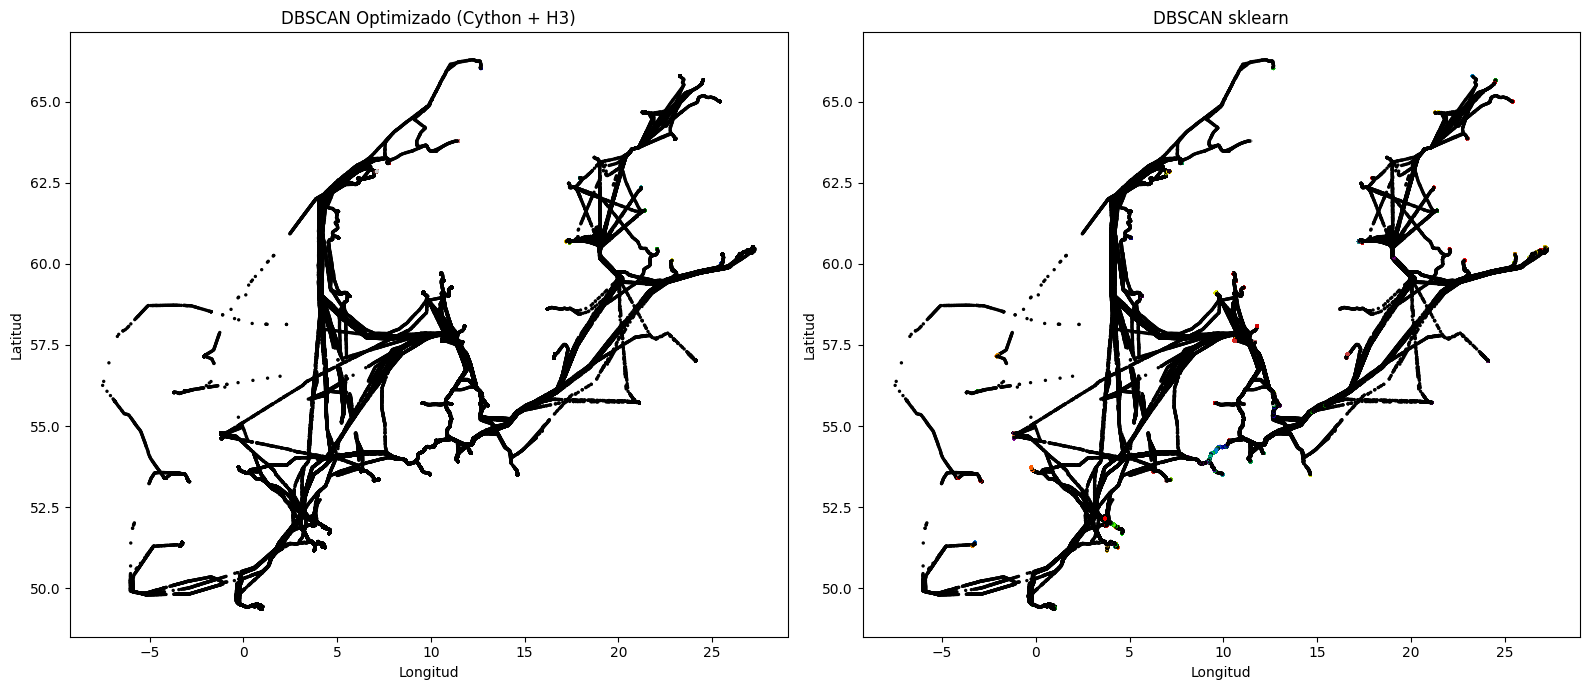

In [20]:
# Reindexar los clusters para que los colores sean consistentes
df_opt["cluster_vis"] = -1
df_opt["cluster_sklearn_vis"] = -1

mask_opt = df_opt["cluster"] != -1
mask_sk = df_opt["cluster_sklearn"] != -1

df_opt.loc[mask_opt, "cluster_vis"] = pd.factorize(df_opt.loc[mask_opt, "cluster"])[0]
df_opt.loc[mask_sk, "cluster_sklearn_vis"] = pd.factorize(df_opt.loc[mask_sk, "cluster_sklearn"])[0]

# Visualización comparativa
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

axs[0].scatter(df_opt["longitude"], df_opt["latitude"], c=df_opt["cluster_vis"], cmap="nipy_spectral", s=2)
axs[0].set_title("DBSCAN Optimizado (Cython + H3)")

axs[1].scatter(df_opt["longitude"], df_opt["latitude"], c=df_opt["cluster_sklearn_vis"], cmap="nipy_spectral", s=2)
axs[1].set_title("DBSCAN sklearn")

for ax in axs:
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")


plt.tight_layout()
plt.show()

In [14]:
df_opt["cluster"].value_counts().head(10)

cluster
-1           92938
 588             5
 46711924        5
 296             4
 589             4
 1181            3
 22783           3
 11677898        3
 1178            3
 295             3
Name: count, dtype: int64

In [16]:
df["res_8"].value_counts().describe()

count    40329.000000
mean         2.393737
std         18.823732
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1903.000000
Name: count, dtype: float64

In [17]:
valid_clusters = df_opt.groupby("res_8")["cluster"].apply(lambda x: (x != -1).sum())
print("res_8 con al menos 1 punto en clúster:", (valid_clusters > 0).sum())
print("Total de res_8:", len(valid_clusters))

res_8 con al menos 1 punto en clúster: 26
Total de res_8: 40329
